# OIH Queries 

What follows are some example SPARQL queries used in OIH for the test interface


## Setup and inits

### Installs

In [80]:
# %%capture
#@title
!pip install -q SPARQLWrapper
!pip install -q cython
# !pip install -q cartopy
!pip install -q geopandas
!pip install -q contextily==1.0rc2
!pip install -q pyshacl
!pip install -q 'PyLD>=2.0.3'
!pip install -q flatten_json
!pip install -q 'fsspec>=0.3.3'
!pip install -q s3fs
!pip -q install SPARQLWrapper
# !pip install -q boto3
# !pip install -q kglab

### Imports

In [81]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import dask, boto3
import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
# import kglab as kg

oih = "https://graph.collaborium.io/blazegraph/namespace/oih/sparql"
oihdev = "https://graph.collaborium.io/blazegraph/namespace/development/sparql"
oihad = "https://graph.collaborium.io/blazegraph/namespace/aquadocs/sparql"

### Support Functions

In [82]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

## Queries

What follows is a set of queries designed to provide a feel for the OIH graph

### Simple Count

How many triples are there?

In [83]:
rq_count = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s ?p ?o } 
  }
"""

In [84]:
dfsc = get_sparql_dataframe(oihdev, rq_count)
dfsc.head()

,Triples
0,1934057


## Type counts


In [85]:
rq_types = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s a <https://schema.org/Organization> } 
  }
"""

In [86]:
dfsc = get_sparql_dataframe(oihdev, rq_types)
dfsc.head()

,Triples
0,21511


### Predicate Counts

This gives an overview of unique predicates that connect a subject to an object.  This gives us both an idea of the properties we are using on things and count of their usage.


In [87]:
rq_pcount = """SELECT ?p (COUNT(?p) as ?pCount)
WHERE
{
  ?s ?p ?o .
}
GROUP BY ?p
"""

In [88]:
dfc = get_sparql_dataframe(oihdev, rq_pcount)
dfc['pCount'] = dfc["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [90]:
dfc_sorted = dfc.sort_values('pCount', ascending=False)
dfc_sorted.head(10)

,p,pCount
56,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,483061
2,https://schema.org/name,180281
8,https://schema.org/keywords,146707
4,https://schema.org/url,103699
0,https://schema.org/description,95460
48,https://schema.org/knowsAbout,67752
19,http://www.w3.org/ns/prov#value,66668
5,https://schema.org/author,55493
10,https://schema.org/itemListElement,40536
1,https://schema.org/identifier,39801


In [91]:
rcount = len(dfc_sorted)
print(rcount)

58


In [92]:
ts = dfc_sorted.tail(38)['pCount'].sum()
print(ts)

312621


In [93]:
hs = dfc_sorted.head(10)
hs.append({'p':'Other','pCount':ts}, ignore_index=True) 
# hs.set_index('p', inplace=True)
hs.head(15)

,p,pCount
56,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,483061
2,https://schema.org/name,180281
8,https://schema.org/keywords,146707
4,https://schema.org/url,103699
0,https://schema.org/description,95460
48,https://schema.org/knowsAbout,67752
19,http://www.w3.org/ns/prov#value,66668
5,https://schema.org/author,55493
10,https://schema.org/itemListElement,40536
1,https://schema.org/identifier,39801


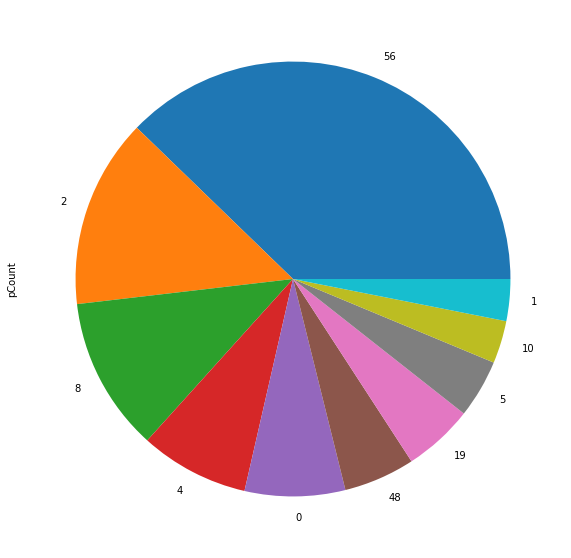

In [94]:
plot = hs.plot.pie(y='pCount',x='p',legend=False, figsize=(10, 10))

### OIH Base Query

In [13]:
rq_main = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s   ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }

        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [32]:
df = get_sparql_dataframe(oihdev, rq_main)
df.head(5)

,g,s,type,score,name,url,lit,description,headline
0,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/35000,https://schema.org/CreativeWork,1.0,Promising marine species for hatchery,https://www.oceandocs.org/handle/1834/35000,Coral,,None
1,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/2013,https://schema.org/CreativeWork,1.0,Interacciones entre corales y macroalgas: depe...,https://www.oceandocs.org/handle/1834/2013,Coral,- Macroalgae proliferation on coral reefs has...,None
2,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/18666,https://schema.org/CreativeWork,1.0,Observations on Florida reef corals treated wi...,https://www.oceandocs.org/handle/1834/18666,coral,- (24pp.) -,None
3,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/20117,https://schema.org/CreativeWork,1.0,M/V CONNECTED Coral Reef Restoration Monitorin...,https://www.oceandocs.org/handle/1834/20117,Coral,- This document presents the results of the m...,None
4,urn:gleaner:summoned:aquadocs:5d5193e7e253bbb1...,oai:aquadocs.org:1834/3262,https://schema.org/CreativeWork,1.0,Los corales (Anthozoa e Hidrozoa) de la bahÃ­a...,https://www.oceandocs.org/handle/1834/3262,Coral,- En el presente trabajo se describe las form...,None


### OIH Gleaner Query

In [15]:
rq_maingl = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [33]:
df = get_sparql_dataframe(oihdev, rq_maingl)
df.head(5)

,g,s,wat,orgname,domain,type,score,name,url,lit,description,headline
0,urn:gleaner:milled:obis:18d1180a74c200d06f9114...,t416560,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/46005357-02b8-4f17-b0...,coral,The purpose of the Coral Reef Evaluation and M...,None
1,urn:gleaner:milled:obis:24bac898cda34444176ec4...,t419335,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/d4ec17b8-fc96-49b9-b7...,coral,The purpose of the Coral Reef Evaluation and M...,None
2,urn:gleaner:milled:obis:24d453e3a4ea6d1f117e5c...,t419362,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/36bca81c-6d77-4fd4-a9...,coral,The purpose of the Coral Reef Evaluation and M...,None
3,urn:gleaner:milled:obis:2bf98aa888d856b8706176...,t420960,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project F...,https://obis.org/dataset/431f96f7-521c-4182-ae...,coral,The purpose of the Coral Reef Evaluation and M...,None
4,urn:gleaner:milled:obis:2d67f3625478df2c1520ae...,t421259,https://www.re3data.org/repository/obis,Ocean Biodiversity Information System,https://obis.org,https://schema.org/Dataset,1.0,Coral Reef Evaluation and Monitoring Project D...,https://obis.org/dataset/d88a91c1-2685-4afa-9a...,coral,The purpose of the Coral Reef Evaluation and M...,None


## Query for prov

Count (count(distinct ?tag) as ?count) 

Need to look for the date in the prov record too.  I keep it by day granularity, so I should be able to see the difference if I focos on a specific repo or look over the dates

In [17]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

In [18]:
rq_prov2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT ( COUNT(?s) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           graph ?g {
             VALUES (?type) { ( schema:CreativeWork ) ( schema:Map )  ( schema:Person )  ( schema:Organization )  ( schema:Dataset )  ( schema:Course ) } 
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
                GROUP BY ?wat ?orgname ?domain

        """

In [34]:
dfp = get_sparql_dataframe(oihdev, rq_prov2)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp.head(10)

,count,wat,domain
orgname,,,
Marine Training EU,937,https://www.re3data.org/repository/marinetraining,https://marinetraining.eu/
Ocean Best Practices,8562,https://www.re3data.org/repository/obps,https://oih.oceanbestpractices.org
Ocean Biodiversity Information System,9140,https://www.re3data.org/repository/obis,https://obis.org
OceanExpert UNESCO/IOC Project Office for IODE,44455,https://www.re3data.org/repository/oceanexpert,https://oceanexpert.org/


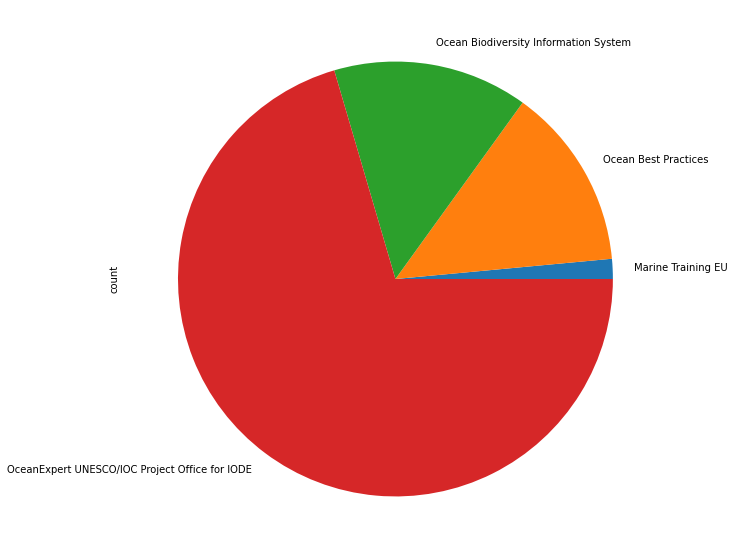

In [35]:
plot = dfp.plot.pie(y='count',legend=False, figsize=(10, 10))

In [21]:
rq_provdate = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?s) as ?count) ?time ?orgname  
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?time ?orgname  
        """

In [36]:
dfpd = get_sparql_dataframe(oihdev, rq_provdate)
dfpd.head(10)

,count,time,orgname
0,313,2021-09-25T00:00:00.000Z,Marine Training EU
1,4249,2021-09-25T00:00:00.000Z,Ocean Biodiversity Information System
2,1,2021-09-25T00:00:00.000Z,Ocean Best Practices
3,28771,2021-09-25T00:00:00.000Z,OceanExpert UNESCO/IOC Project Office for IODE


In [37]:
dfpd = get_sparql_dataframe(oihdev, rq_provdate)
dfpd['count'] = dfpd["count"].astype(int) # convert count c to int
dfpd.set_index('time', inplace=True)
dfpd.head()


,count,orgname
time,,
2021-09-25T00:00:00.000Z,313,Marine Training EU
2021-09-25T00:00:00.000Z,1,Ocean Best Practices
2021-09-25T00:00:00.000Z,4249,Ocean Biodiversity Information System
2021-09-25T00:00:00.000Z,28771,OceanExpert UNESCO/IOC Project Office for IODE


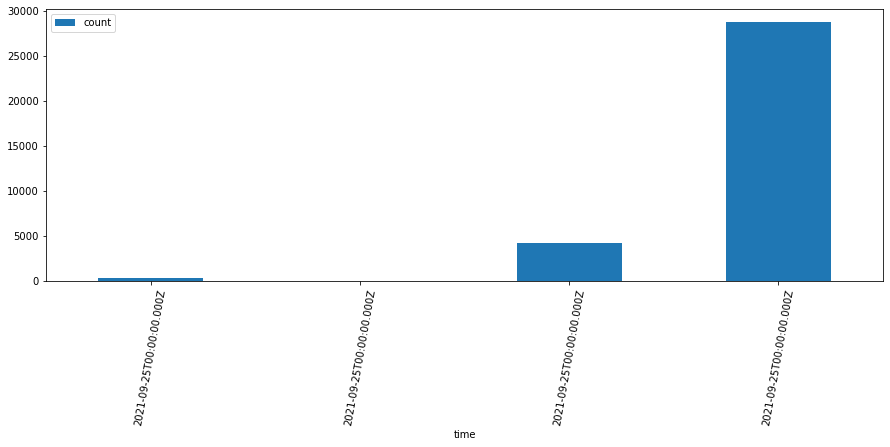

In [38]:
ax = dfpd.plot.bar(rot=80, stacked=True, figsize=(15, 5))

## Feed query

Goal here is see if the prov will give us the elements for an RSS feed.  
The [RSS specs](https://validator.w3.org/feed/docs/rss2.html) give us the elements we need to populate.  Focus on; title(name), date, author, description

* Element 	Description 	Example
* title 	The title of the item. 	Venice Film Festival Tries to Quit Sinking
* link 	The URL of the item. 	http://www.nytimes.com/2002/09/07/movies/07FEST.html
* description 	The item synopsis. 	Some of the most heated chatter at the Venice Film Festival this week was about the way that the arrival of the stars at the Palazzo del Cinema was being staged.
* author 	Email address of the author of the item. More. 	oprah@oxygen.net
* category 	Includes the item in one or more categories. More. 	Simpsons Characters
* comments 	URL of a page for comments relating to the item. More. 	http://www.myblog.org/cgi-local/mt/mt-comments.cgi?entry_id=290
* enclosure 	Describes a media object that is attached to the item. More. 	<enclosure url="http://live.curry.com/mp3/celebritySCms.mp3" length="1069871" type="audio/mpeg"/>
* guid 	A string that uniquely identifies the item. More. 	<guid isPermaLink="true">http://inessential.com/2002/09/01.php#a2</guid>
* pubDate 	Indicates when the item was published. More. 	Sun, 19 May 2002 15:21:36 GMT
* source 	The RSS channel that the item came from. More. 	<source url="http://www.quotationspage.com/data/qotd.rss">Quotes of the Day</source>

In [39]:
rq_provdatelist = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT  ?time ?orgname ?memval  ?memname ?memdesc
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:value ?memval .
           ?mem schema:name ?memname .
           ?mem schema:description ?memdesc .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?time)
        LIMIT 1000

        """

In [40]:
dfpl = get_sparql_dataframe(oihdev, rq_provdatelist)
dfpl.head(10)

,time,orgname,memval,memname,memdesc
0,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/3955,Aquaculture Production and Environmental Impacts,The course gives an overview of world aquacult...
1,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/3870,Biological Rhythms,Course content\n\nThis course focuses on biolo...
2,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4280,Geographical Information Systems (GIS) in Envi...,Course introduction\n\nThe aim is to introduce...
3,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4203,Marine Structures 2,General course objectives\n\nTo learn how to a...
4,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4304,Studying Marine Mammals in the Wild,Course Description:\n\nThe course will be held...
5,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4052,Theory of Hydrodynamic Stability,"Course content\n\nThe Orr-Sommerfeld equation,..."
6,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4244,Offshore Wind Energy,General course objectives\n\nTo be able to cal...
7,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4059,Coastal Benthic Ecology,Contents\n\nThe course provides a thorough int...
8,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/3972,Offshore Field Development,Contents\n\nThis course gives an overview of t...
9,2021-09-25T00:00:00.000Z,Marine Training EU,https://www.marinetraining.eu/node/4347,Adaptation Planning,Course Description:\n\nThe course examines cha...


## Types Breakdown


In [78]:
rq_types = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?type) as ?count) ?type   
        WHERE
        {
           ?s rdf:type ?type
           FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization, schema:Dataset, schema:Person, schema:Map, schema:Course, schema:Event, schema:Vehicle) )
        }
        GROUP BY ?type  
        ORDER BY DESC(?count)
        """

In [79]:
dft = get_sparql_dataframe(oihdev, rq_types)
dft['count'] = dft["count"].astype(int) # convert count c to int
dft.set_index('type', inplace=True)
dft.head(10)

,count
type,
https://schema.org/Person,74543
https://schema.org/Event,20160
https://schema.org/Organization,15654
https://schema.org/Dataset,4248
https://schema.org/Course,822


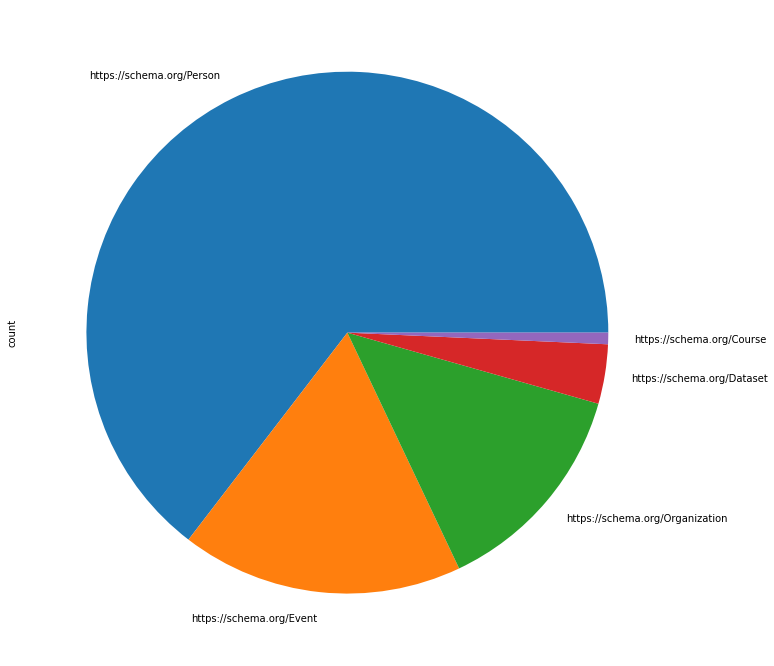

In [75]:
plot_t = dft.plot.pie(y='count',legend=False, figsize=(12, 12))